# Jedeschule API Notebook

This notebook demonstrates how to use the [jedeschule-api](https://github.com/codeforberlin/jedeschule-api) to query information about German schools.

**First, we install required dependencies.**

In [ ]:
# Install required packages (run this once in fresh environments)
!pip install requests pandas matplotlib

In [7]:
# Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set base API URL to a working deployment
BASE_URL = "https://jedeschule.codefor.de"

## 1. Get Available Filter Parameters

In [8]:
# Request available filtering options (state, school_type, legal_status)
response = requests.get(f"{BASE_URL}/filter_params")
filter_params = response.json()

print("Available States (ISO codes):", filter_params['state'])
print("\nAvailable School Types:", filter_params['school_type'])
print("\nLegal Statuses:", filter_params['legal_status'])

Available States (ISO codes): ['HH', 'BB', 'HB', 'NI', 'HE', 'BE', 'NW', 'BW', 'BY', 'SN', 'SL', 'RP', 'ST', 'MV', 'TH', 'SH']

Available School Types: ['Bischöfliche Realschule des Bistums Trier', 'OSZ mit beruflichem Gymnasium', 'Berufsfachschule', 'Grundschule mit schulartunabhängiger Orientierungsstufe', 'Mittelschulen', 'Berufliche Gymnasien|Berufsfachschule|Berufsschule|Berufsvorbereitungsschule|Fachoberschule', 'Schule mit dem Förderschwerpunkt emotionale und soziale Entwicklung', 'Gemeinschaftsschule ;\xa0\t\t\t\t\t\t\t\t\t\t Förderzentrum ;\xa0\t\t\t\t\t\t\t\t\t\t Gymnasium ;\xa0\t\t\t\t\t\t\t\t\t\t Hauptschule ;\xa0\t\t\t\t\t\t\t\t\t\t Realschule ;', 'Regelschule in freier Trägerschaft', 'Kooperative Gesamtschule mit Mittelstufenschule', 'Freie Waldorfförderschule', 'Berufsvorbereitungsschule (allg. bild.)', 'Grund-, Haupt- und Realschule', 'Waldorfschule für Lern- und Erziehungshilfe', 'Berufliche Gymnasien|Berufsfachschule|Berufsschule|Berufsvorbereitungsschule', 'Dependanc

## 2. Get School Statistics by State

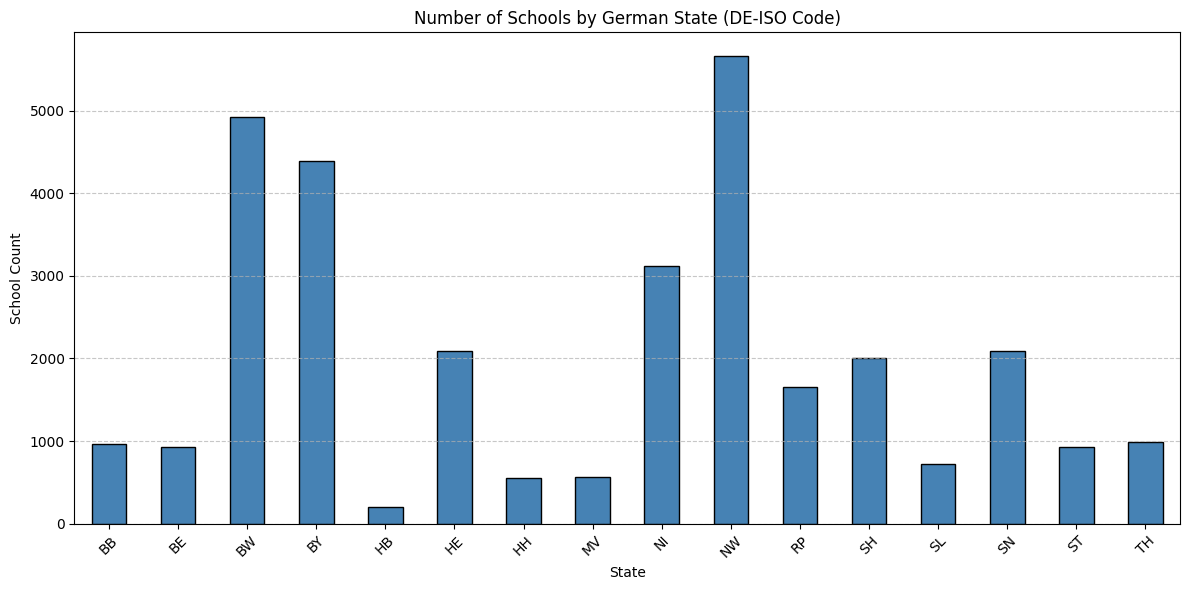

,count,last_updated
state,,
BB,960,2025-08-09
BE,926,2025-08-09
BW,4922,2025-08-09
BY,4392,2025-08-09
HB,207,2025-08-09
HE,2095,2025-08-09
HH,558,2025-08-09
MV,561,2025-08-09
NI,3122,2025-08-09


In [9]:
# Get school stats per state
response = requests.get(f"{BASE_URL}/stats")
stats = response.json()

# Convert to DataFrame
df_stats = pd.DataFrame(stats)
df_stats.set_index('state', inplace=True)

# Plot bar chart
plt.figure(figsize=(12, 6))
df_stats['count'].plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Number of Schools by German State (DE-ISO Code)')
plt.xlabel('State')
plt.ylabel('School Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display data
df_stats[['count', 'last_updated']].head(10)

## 3. Search Schools with Filters

In [10]:
# Query schools with optional filters
# Example: Get up to 10 schools from Berlin (BE) containing "Gymnasium" in name

params = {
    "state": ["BE"],
    "name": "Gymnasium",
    "limit": 10,
    "skip": 0
}

response = requests.get(f"{BASE_URL}/schools/", params=params)
schools = response.json()

# Convert to DataFrame
df_schools = pd.DataFrame(schools)
if not df_schools.empty:
    df_schools[['id', 'name', 'city', 'school_type', 'address', 'zip']].reset_index(drop=True)
else:
    print("No schools found for the given criteria.")

## 4. Get a Specific School by ID

In [11]:
# Use a school ID from the previous result
if 'df_schools' in locals() and not df_schools.empty:
    example_school_id = df_schools.iloc[0]['id']
else:
    example_school_id = "BE_001"  # fallback ID

response = requests.get(f"{BASE_URL}/schools/{example_school_id}")

if response.status_code == 200:
    school_detail = response.json()
    display(pd.DataFrame([school_detail]))
else:
    print(f"Error: {response.status_code} - {response.text}")

,id,name,address,city,email,fax,latitude,legal_status,longitude,phone,school_type,zip,update_timestamp
0,BE-02Y07,Robert-Koch-Gymnasium,Dieffenbachstraße 60,Berlin,Koch-Gymnasium@web.de,+49 30 50585735,52.49299,öffentlich,13.415714,+49 30 50585731,Gymnasium,10967,2025-08-09T16:33:39.396145


## 5. Search Schools Near a Geographic Point (e.g., Berlin)

In [12]:
# Coordinates for central Berlin
berlin_lat = 52.52437
berlin_lon = 13.36796

params = {
    "by_lat": berlin_lat,
    "by_lon": berlin_lon,
    "limit": 5,
    "state": ["BE"]
}

response = requests.get(f"{BASE_URL}/schools/", params=params)
nearby_schools = response.json()

df_nearby = pd.DataFrame(nearby_schools)
if not df_nearby.empty:
    df_nearby[['id', 'name', 'city', 'address', 'latitude', 'longitude']].reset_index(drop=True)
else:
    print("No nearby schools found.")

## 6. Bounding Box Filter (e.g., Around Hamburg)

In [13]:
# Define bounding box (top, bottom, left, right) in WGS84
bbox = {
    "bb_top": 53.6,
    "bb_bottom": 53.4,
    "bb_left": 9.8,
    "bb_right": 10.2
}

response = requests.get(f"{BASE_URL}/schools/", params=bbox)
bbox_schools = response.json()

df_bbox = pd.DataFrame(bbox_schools)
if not df_bbox.empty:
    df_bbox[['name', 'city', 'school_type', 'latitude', 'longitude']].reset_index(drop=True)
else:
    print("No schools found within the specified bounding box.")

## 7. Search Schools Updated After a Specific Date

In [14]:
# Get schools updated after January 1, 2024
params = {
    "update_timestamp": "2024-01-01",
    "limit": 5
}

response = requests.get(f"{BASE_URL}/schools/", params=params)
updated_schools = response.json()

df_updated = pd.DataFrame(updated_schools)
if not df_updated.empty:
    df_updated[['name', 'city', 'update_timestamp']].reset_index(drop=True)
else:
    print("No schools updated after 2024-01-01 found.")

## Notes

- All geographic coordinates use **WGS84 (EPSG:4326)**.
- Combine filters like `state`, `name`, `by_lat/by_lon`, or `update_timestamp`.
- Use `skip` and `limit` for pagination (`limit` default: 100).
- Add `include_raw=true` to get raw scraped data for debugging.

🔧 **Tip**: Export results:
```python
df_schools.to_csv('german_schools.csv', index=False)
```